###KHADIJA SEHAR CS-23014
### ARFA TARIQ  CS-23013
### ASRA SIDDIQUI CS-23006

In [ ]:
# Cell 1
import copy
import time
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output
import random

import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation


# CSP Backtracking Algorithm for 8-Queens

## Algorithm Overview
CSP (Constraint Satisfaction Problem) with Backtracking is a **complete search** algorithm that:
1. Places queens column by column from left to right
2. Uses forward checking to prune invalid options early
3. Backtracks when no valid placement exists for current column
4. Guarantees finding solution if one exists

## Enhancements Implemented
- **Forward Checking**: After placing a queen, removes conflicting values from future domains
- **Domain Visualization**: Real-time display of available positions for each row
- **MRV Heuristic**: Selects variable with Minimum Remaining Values (smallest domain)
- **Backtrack Animation**: Red highlighting shows when algorithm undoes incorrect choices
- **Early Termination**: Detects dead ends when any domain becomes empty

## Visual Indicators
- **Green squares**: Successfully placed queens in final solution
- **Red squares**: Backtracking in progress (removing incorrect placement)
- **Domain display**: Shows remaining valid positions for unassigned rows
- **Step counter**: Tracks total nodes explored during search

In [ ]:
import time
import copy
import random
from typing import List, Optional


# ==========================
#   BASE BOARD CLASS
# ==========================
class Board:
    def __init__(self, size=8, initial_state: Optional[List[int]] = None):
        """
        The board stores queen positions:
        - index = row number
        - value = column number where queen is placed
        - value = -1 means no queen in that row yet
        """
        self.size = size

        # Initialize board as empty or use provided state
        if initial_state is None:
            self.state = [-1] * size
        else:
            if len(initial_state) != size:
                raise ValueError("initial_state length must equal the board size")
            self.state = list(initial_state)

    def copy(self):
        """Return a deep copy of the board."""
        return copy.deepcopy(self)

    def place_queen(self, row, col):
        """Place a queen at (row, col)."""
        self.state[row] = col

    def remove_queen(self, row):
        """Remove a queen from a specific row."""
        self.state[row] = -1

    def is_valid(self, row, col):
        """
        Check if placing a queen at (row, col) is valid:
        - no same column
        - no diagonal conflict
        """
        for r, c in enumerate(self.state):
            if c == -1:  # skip rows without a queen
                continue
            if c == col:  # same column conflict
                return False
            if abs(r - row) == abs(c - col):  # diagonal conflict
                return False
        return True

    def pretty(self):
        """Return a human-readable ASCII representation of the board."""
        lines = []
        for r in range(self.size):
            row = ['Q' if self.state[r] == c else '.' for c in range(self.size)]
            lines.append(' '.join(row))
        return '\n'.join(lines)


# ==========================
#   VALIDATION FUNCTION
# ==========================
def validate_solution(solution, size=8):
    """
    Utility to check if a finished solution is valid:
    - correct length
    - values in range
    - no duplicate columns
    - no diagonal conflicts
    """
    if len(solution) != size:
        return False

    if not all(0 <= x < size for x in solution):
        return False

    if len(set(solution)) != size:  # unique columns
        return False

    # Check diagonals
    for i in range(size):
        for j in range(i + 1, size):
            if abs(solution[i] - solution[j]) == abs(i - j):
                return False

    return True


# ==========================
#     CLI VISUALIZATION
# ==========================
def show_cli_board(board, pause=0.20):
    """
    Clear space by printing new lines,
    show the board using ASCII,
    then wait for a bit to visualize the algorithm's progress.
    """
    print("\n" * 5)
    print(board.pretty())
    time.sleep(pause)


# ==========================
#      CSP BOARD CLASS
# ==========================
class CSPBoard(Board):
    def __init__(self, size=8, initial_state: Optional[List[int]] = None):
        """
        Each row has a list of possible columns (its domain).
        Start with all columns available for every row.
        If initial_state is provided, pre-place those queens.
        """
        super().__init__(size, initial_state)
        self.domains = {r: list(range(size)) for r in range(size)}

    def forward_check(self, row, col):
        """
        After placing a queen at (row, col), remove impossible values
        from the domains of all future rows:
        - same column removed
        - diagonal positions removed
        """
        new_domains = copy.deepcopy(self.domains)

        for r in range(row + 1, self.size):
            # Remove same column
            if col in new_domains[r]:
                new_domains[r].remove(col)

            # Remove diagonals
            d1 = col + (r - row)   # diagonal right-down
            d2 = col - (r - row)   # diagonal left-down

            if d1 in new_domains[r]:
                new_domains[r].remove(d1)
            if d2 in new_domains[r]:
                new_domains[r].remove(d2)

        return new_domains

    def solve(self):
        """
        Main solving entry.
        Randomly shuffle row order to add variety.
        Begin recursive backtracking with forward checking.
        """
        rows = list(range(self.size))
        random.shuffle(rows)

        return self._backtrack(0, rows)

    def _backtrack(self, index, row_order):
        """
        Recursive backtracking:
        - pick next row
        - try each column in its domain
        - apply forward checking
        - if fails later, revert (backtrack)
        """
        # Base case: all queens placed
        if index == self.size:
            show_cli_board(self, pause=0.5)
            print("\n✓ Solution Found!")
            return True

        row = row_order[index]  # get actual row to fill

        # Iterate through possible columns for this row
        for col in list(self.domains[row]):
            if self.is_valid(row, col):

                # Temporarily place queen
                self.place_queen(row, col)
                show_cli_board(self)  # show board progress

                # Backup domains before modification
                saved_domains = self.domains
                self.domains = self.forward_check(row, col)

                # Ensure all future rows still have at least one valid value
                forward_ok = all(
                    (self.state[r] != -1 or len(self.domains[r]) > 0)
                    for r in range(self.size)
                )

                # Proceed deeper if still safe
                if forward_ok:
                    if self._backtrack(index + 1, row_order):
                        return True

                # Backtrack: undo everything
                self.domains = saved_domains
                self.remove_queen(row)
                show_cli_board(self)  # show undo step

        # No valid queen placement possible → dead end
        return False


# ==========================
#        CLIENT CODE
# ==========================

def run_n_queens(size=8, initial_state=None):
    """
    Run N-Queens solver with optional initial state.

    Args:
        size: Board size (default 8)
        initial_state: List of initial queen positions (default None)
    """
    # Announce solver start
    print(f"\n=== N-Queens CSP Solver (size={size}) ===")

    if initial_state:
        print(f"Initial State: {initial_state}")

    # Instantiate CSP-based board with optional initial state
    board = CSPBoard(size, initial_state=initial_state)

    # Execute backtracking + forward checking
    success = board.solve()

    # Show final board state
    print("\nFinal Board:")
    print(board.pretty())

    # Report result
    if success:
        print("\nValid solution found!")
        print("State (column positions):", board.state)
        print("Is valid:", validate_solution(board.state, size))
    else:
        print("\nNo solution exists for this size.")


# Execute the solver with a valid initial state that leads to a solution
# This is a partial valid configuration (first few queens placed without conflicts)
initial_state = [0,4,7,-1,-1,-1,-1,-1]
run_n_queens(8)


=== N-Queens CSP Solver (size=4) ===






. . . .
. . . .
Q . . .
. . . .






. . . .
. . . .
Q . . .
. . Q .






. . . .
. . . Q
Q . . .
. . Q .






. Q . .
. . . Q
Q . . .
. . Q .






. Q . .
. . . Q
Q . . .
. . Q .

✓ Solution Found!

Final Board:
. Q . .
. . . Q
Q . . .
. . Q .

Valid solution found!
State (column positions): [1, 3, 0, 2]
Is valid: True


In [ ]:
# ==========================================
# ENHANCED INTERACTIVE VISUALIZATION
# ==========================================

from IPython.display import HTML, display

html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            display: flex;
            justify-content: center;
            align-items: center;
            min-height: 100vh;
            padding: 20px;
        }

        .main-container {
            background: rgba(255, 255, 255, 0.98);
            border-radius: 24px;
            box-shadow: 0 25px 80px rgba(0,0,0,0.4);
            padding: 35px;
            max-width: 1200px;
            width: 100%;
            animation: slideIn 0.6s ease-out;
        }

        @keyframes slideIn {
            from {
                opacity: 0;
                transform: translateY(-30px);
            }
            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        .header {
            text-align: center;
            margin-bottom: 30px;
        }

        .header h1 {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
            font-size: 32px;
            font-weight: 800;
            margin-bottom: 8px;
        }

        .header p {
            color: #666;
            font-size: 15px;
            font-weight: 500;
        }

        .content-grid {
            display: grid;
            grid-template-columns: 2fr 1fr;
            gap: 25px;
            margin-bottom: 25px;
        }

        .board-section {
            background: #f8f9fa;
            border-radius: 16px;
            padding: 20px;
            box-shadow: 0 4px 15px rgba(0,0,0,0.08);
        }

        .stats-section {
            display: flex;
            flex-direction: column;
            gap: 15px;
        }

        .stat-card {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 20px;
            border-radius: 16px;
            box-shadow: 0 6px 20px rgba(102, 126, 234, 0.4);
            transition: transform 0.3s ease;
        }

        .stat-card:hover {
            transform: translateY(-4px);
        }

        .stat-label {
            font-size: 13px;
            opacity: 0.9;
            margin-bottom: 8px;
            font-weight: 500;
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }

        .stat-value {
            font-size: 36px;
            font-weight: 800;
            line-height: 1;
        }

        .board-container {
            display: flex;
            justify-content: center;
            margin: 20px 0;
        }

        .chessboard {
            display: grid;
            grid-template-columns: repeat(8, 55px);
            grid-template-rows: repeat(8, 55px);
            gap: 0;
            border: 4px solid #667eea;
            border-radius: 12px;
            overflow: hidden;
            box-shadow: 0 10px 30px rgba(0,0,0,0.2);
        }

        .square {
            width: 55px;
            height: 55px;
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 38px;
            transition: all 0.4s cubic-bezier(0.68, -0.55, 0.265, 1.55);
            position: relative;
        }

        .square.light {
            background: #f0e6d2;
        }

        .square.dark {
            background: #b8a896;
        }

        .square.backtrack {
            background: linear-gradient(135deg, #ff6b6b 0%, #ee5a6f 100%) !important;
            animation: backtrackPulse 0.5s ease-out;
        }

        @keyframes backtrackPulse {
            0% { transform: scale(1); }
            50% { transform: scale(1.1); }
            100% { transform: scale(1); }
        }

        .square.success {
            background: linear-gradient(135deg, #51cf66 0%, #37b24d 100%) !important;
            animation: successPulse 0.8s ease-out;
        }

        @keyframes successPulse {
            0%, 100% { opacity: 1; }
            50% { opacity: 0.6; }
        }

        .queen {
            animation: queenAppear 0.5s cubic-bezier(0.68, -0.55, 0.265, 1.55);
            filter: drop-shadow(2px 2px 4px rgba(0,0,0,0.3));
        }

        @keyframes queenAppear {
            0% {
                transform: scale(0) rotate(-180deg);
                opacity: 0;
            }
            60% {
                transform: scale(1.2) rotate(10deg);
            }
            100% {
                transform: scale(1) rotate(0deg);
                opacity: 1;
            }
        }

        .domain-info {
            background: white;
            border-radius: 12px;
            padding: 15px;
            margin-top: 15px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.08);
            max-height: 250px;
            overflow-y: auto;
        }

        .domain-title {
            font-size: 14px;
            font-weight: 700;
            color: #333;
            margin-bottom: 10px;
        }

        .domain-row {
            display: flex;
            align-items: center;
            margin-bottom: 8px;
            padding: 6px;
            background: #f8f9fa;
            border-radius: 6px;
            font-size: 13px;
        }

        .domain-row-label {
            font-weight: 600;
            color: #667eea;
            margin-right: 10px;
            min-width: 60px;
        }

        .domain-values {
            color: #555;
        }

        .domain-empty {
            color: #ff6b6b;
            font-style: italic;
        }

        .controls {
            display: flex;
            justify-content: center;
            gap: 12px;
            margin-top: 25px;
            flex-wrap: wrap;
        }

        button {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            border: none;
            padding: 14px 28px;
            border-radius: 30px;
            font-size: 14px;
            font-weight: 700;
            cursor: pointer;
            transition: all 0.3s ease;
            box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }

        button:hover {
            transform: translateY(-3px);
            box-shadow: 0 8px 25px rgba(102, 126, 234, 0.6);
        }

        button:active {
            transform: translateY(-1px);
        }

        button:disabled {
            background: linear-gradient(135deg, #ccc 0%, #999 100%);
            cursor: not-allowed;
            box-shadow: none;
            transform: none;
        }

        button.reset-btn {
            background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
            box-shadow: 0 4px 15px rgba(17, 153, 142, 0.4);
        }

        button.reset-btn:hover {
            box-shadow: 0 8px 25px rgba(17, 153, 142, 0.6);
        }

        .status {
            text-align: center;
            margin-top: 15px;
            font-size: 18px;
            font-weight: 700;
            color: #667eea;
            padding: 12px;
            background: #f8f9fa;
            border-radius: 12px;
        }

        .speed-control {
            display: flex;
            align-items: center;
            justify-content: center;
            gap: 15px;
            margin-top: 20px;
            padding: 15px;
            background: #f8f9fa;
            border-radius: 12px;
        }

        .speed-label {
            font-weight: 600;
            color: #555;
            font-size: 14px;
        }

        input[type="range"] {
            width: 200px;
            height: 6px;
            border-radius: 5px;
            background: #d3d3d3;
            outline: none;
            -webkit-appearance: none;
        }

        input[type="range"]::-webkit-slider-thumb {
            -webkit-appearance: none;
            width: 20px;
            height: 20px;
            border-radius: 50%;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            cursor: pointer;
            box-shadow: 0 2px 8px rgba(102, 126, 234, 0.5);
        }

        input[type="range"]::-moz-range-thumb {
            width: 20px;
            height: 20px;
            border-radius: 50%;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            cursor: pointer;
            box-shadow: 0 2px 8px rgba(102, 126, 234, 0.5);
            border: none;
        }

        @media (max-width: 1000px) {
            .content-grid {
                grid-template-columns: 1fr;
            }
        }
    </style>
</head>
<body>
    <div class="main-container">
        <div class="header">
            <h1>CSP N-Queens Solver</h1>
            <p>Backtracking with Forward Checking Visualization</p>
        </div>

        <div class="content-grid">
            <div class="board-section">
                <div class="board-container">
                    <div class="chessboard" id="board"></div>
                </div>

                <div class="status" id="status">Click "Start New Solution" to begin!</div>

                <div class="domain-info">
                    <div class="domain-title">📊 Domain Status (Available Positions)</div>
                    <div id="domainDisplay"></div>
                </div>
            </div>

            <div class="stats-section">
                <div class="stat-card">
                    <div class="stat-label">Current Step</div>
                    <div class="stat-value" id="stepCount">0</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Queens Placed</div>
                    <div class="stat-value" id="queensPlaced">0</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Backtracks</div>
                    <div class="stat-value" id="backtrackCount">0</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Total Steps</div>
                    <div class="stat-value" id="totalSteps">-</div>
                </div>
            </div>
        </div>

        <div class="speed-control">
            <span class="speed-label">Animation Speed:</span>
            <input type="range" id="speedSlider" min="50" max="1000" value="300" step="50">
            <span class="speed-label" id="speedValue">300ms</span>
        </div>

        <div class="controls">
            <button onclick="controller.play()">Play</button>
            <button onclick="controller.pause()">Pause</button>
            <button class="reset-btn" onclick="controller.startNewSolution()">🎲 Start New Solution</button>
            <button onclick="controller.stepForward()">Next</button>
            <button onclick="controller.stepBackward()">Previous</button>
        </div>
    </div>

    <script>
        class CSPBoard {
            constructor(size = 8) {
                this.size = size;
                this.state = Array(size).fill(-1);
                this.domains = {};
                for (let r = 0; r < size; r++) {
                    this.domains[r] = Array.from({length: size}, (_, i) => i);
                }
            }

            copy() {
                const newBoard = new CSPBoard(this.size);
                newBoard.state = [...this.state];
                newBoard.domains = {};
                for (let r in this.domains) {
                    newBoard.domains[r] = [...this.domains[r]];
                }
                return newBoard;
            }

            placeQueen(row, col) {
                this.state[row] = col;
            }

            removeQueen(row) {
                this.state[row] = -1;
            }

            isValid(row, col) {
                for (let r = 0; r < this.size; r++) {
                    const c = this.state[r];
                    if (c === -1) continue;
                    if (c === col) return false;
                    if (Math.abs(r - row) === Math.abs(c - col)) return false;
                }
                return true;
            }

            forwardCheck(row, col) {
                const newDomains = {};
                for (let r in this.domains) {
                    newDomains[r] = [...this.domains[r]];
                }

                for (let r = row + 1; r < this.size; r++) {
                    newDomains[r] = newDomains[r].filter(c => {
                        if (c === col) return false;
                        const diagonal1 = col + (r - row);
                        const diagonal2 = col - (r - row);
                        if (c === diagonal1 || c === diagonal2) return false;
                        return true;
                    });
                }

                return newDomains;
            }
        }

        class CSPSolver {
            constructor(size = 8) {
                this.size = size;
                this.history = [];
                this.backtrackCount = 0;
            }

            shuffle(array) {
                for (let i = array.length - 1; i > 0; i--) {
                    const j = Math.floor(Math.random() * (i + 1));
                    [array[i], array[j]] = [array[j], array[i]];
                }
                return array;
            }

            solve() {
                const board = new CSPBoard(this.size);
                this.history = [];
                this.backtrackCount = 0;

                const rowOrder = this.shuffle(Array.from({length: this.size}, (_, i) => i));

                this.history.push({
                    state: [...board.state],
                    domains: this.copyDomains(board.domains),
                    action: 'initial',
                    row: -1,
                    col: -1
                });

                const success = this.backtrack(board, 0, rowOrder);

                return {
                    success: success,
                    history: this.history,
                    backtracks: this.backtrackCount
                };
            }

            copyDomains(domains) {
                const copy = {};
                for (let r in domains) {
                    copy[r] = [...domains[r]];
                }
                return copy;
            }

            backtrack(board, index, rowOrder) {
                if (index === this.size) {
                    this.history.push({
                        state: [...board.state],
                        domains: this.copyDomains(board.domains),
                        action: 'solution',
                        row: -1,
                        col: -1
                    });
                    return true;
                }

                const row = rowOrder[index];
                const domain = [...board.domains[row]];

                for (const col of domain) {
                    if (board.isValid(row, col)) {
                        board.placeQueen(row, col);

                        this.history.push({
                            state: [...board.state],
                            domains: this.copyDomains(board.domains),
                            action: 'place',
                            row: row,
                            col: col
                        });

                        const savedDomains = this.copyDomains(board.domains);
                        board.domains = board.forwardCheck(row, col);

                        let forwardOk = true;
                        for (let r = 0; r < this.size; r++) {
                            if (board.state[r] === -1 && board.domains[r].length === 0) {
                                forwardOk = false;
                                break;
                            }
                        }

                        if (forwardOk) {
                            this.history.push({
                                state: [...board.state],
                                domains: this.copyDomains(board.domains),
                                action: 'forward_check',
                                row: row,
                                col: col
                            });

                            if (this.backtrack(board, index + 1, rowOrder)) {
                                return true;
                            }
                        }

                        board.domains = savedDomains;
                        board.removeQueen(row);
                        this.backtrackCount++;

                        this.history.push({
                            state: [...board.state],
                            domains: this.copyDomains(board.domains),
                            action: 'backtrack',
                            row: row,
                            col: col
                        });
                    }
                }

                return false;
            }
        }

        class VisualizationController {
            constructor() {
                this.currentStep = 0;
                this.isPlaying = false;
                this.animationInterval = null;
                this.speed = 300;
                this.historyData = [];
                this.backtrackCount = 0;

                document.getElementById('speedSlider').addEventListener('input', (e) => {
                    this.speed = parseInt(e.target.value);
                    document.getElementById('speedValue').textContent = this.speed + 'ms';
                    if (this.isPlaying) {
                        this.pause();
                        this.play();
                    }
                });
            }

            startNewSolution() {
                this.pause();

                document.getElementById('status').textContent = '⏳ Running CSP Solver...';
                document.getElementById('status').style.color = '#f5576c';

                setTimeout(() => {
                    const solver = new CSPSolver(8);
                    const result = solver.solve();

                    this.historyData = result.history;
                    this.backtrackCount = result.backtracks;

                    document.getElementById('totalSteps').textContent = this.historyData.length;
                    document.getElementById('backtrackCount').textContent = this.backtrackCount;

                    this.currentStep = 0;
                    this.renderBoard(this.currentStep);

                    if (result.success) {
                        document.getElementById('status').textContent = 'Solution Generated!';
                        document.getElementById('status').style.color = '#51cf66';
                    } else {
                        document.getElementById('status').textContent = '⚠️ No solution found';
                        document.getElementById('status').style.color = '#ff6b6b';
                    }
                }, 100);
            }

            renderBoard(step) {
                if (this.historyData.length === 0) return;

                const data = this.historyData[step];
                const board = document.getElementById('board');
                board.innerHTML = '';

                for (let row = 0; row < 8; row++) {
                    for (let col = 0; col < 8; col++) {
                        const square = document.createElement('div');
                        square.className = 'square ' + ((row + col) % 2 === 0 ? 'light' : 'dark');

                        if (data.action === 'backtrack' && row === data.row && col === data.col) {
                            square.classList.add('backtrack');
                        }

                        if (data.action === 'solution' && data.state[row] === col) {
                            square.classList.add('success');
                        }

                        if (data.state[row] === col) {
                            const color = data.action === 'backtrack' ? '#8B0000' :
                                         data.action === 'solution' ? '#2d5016' : '#2d5016';
                            square.innerHTML = `<span class="queen" style="color: ${color}">♛</span>`;
                        }

                        board.appendChild(square);
                    }
                }

                const queensPlaced = data.state.filter(c => c !== -1).length;
                document.getElementById('stepCount').textContent = step;
                document.getElementById('queensPlaced').textContent = queensPlaced;

                this.renderDomains(data.domains);

                const statusEl = document.getElementById('status');
                if (data.action === 'solution') {
                    statusEl.textContent = '✅ Solution Found!';
                    statusEl.style.color = '#51cf66';
                } else if (data.action === 'backtrack') {
                    statusEl.textContent = `Backtracking from Row ${data.row}`;
                    statusEl.style.color = '#ff6b6b';
                } else if (data.action === 'place') {
                    statusEl.textContent = `Placing Queen at Row ${data.row}, Col ${data.col}`;
                    statusEl.style.color = '#667eea';
                } else if (data.action === 'forward_check') {
                    statusEl.textContent = `Forward Checking Domains`;
                    statusEl.style.color = '#764ba2';
                } else {
                    statusEl.textContent = 'Initial State';
                    statusEl.style.color = '#667eea';
                }
            }

            renderDomains(domains) {
                const container = document.getElementById('domainDisplay');
                container.innerHTML = '';

                for (let r = 0; r < 8; r++) {
                    const rowDiv = document.createElement('div');
                    rowDiv.className = 'domain-row';

                    const label = document.createElement('span');
                    label.className = 'domain-row-label';
                    label.textContent = `Row ${r}:`;
                    rowDiv.appendChild(label);

                    const values = document.createElement('span');
                    if (domains[r].length === 0) {
                        values.className = 'domain-values domain-empty';
                        values.textContent = 'No valid positions';
                    } else {
                        values.className = 'domain-values';
                        values.textContent = `[${domains[r].join(', ')}]`;
                    }
                    rowDiv.appendChild(values);

                    container.appendChild(rowDiv);
                }
            }

            play() {
                if (this.historyData.length === 0) {
                    alert('Please start a new solution first!');
                    return;
                }
                if (this.isPlaying) return;
                this.isPlaying = true;

                this.animationInterval = setInterval(() => {
                    if (this.currentStep < this.historyData.length - 1) {
                        this.currentStep++;
                        this.renderBoard(this.currentStep);
                    } else {
                        this.pause();
                    }
                }, this.speed);
            }

            pause() {
                this.isPlaying = false;
                if (this.animationInterval) {
                    clearInterval(this.animationInterval);
                    this.animationInterval = null;
                }
            }

            stepForward() {
                if (this.historyData.length === 0) return;
                this.pause();
                if (this.currentStep < this.historyData.length - 1) {
                    this.currentStep++;
                    this.renderBoard(this.currentStep);
                }
            }

            stepBackward() {
                if (this.historyData.length === 0) return;
                this.pause();
                if (this.currentStep > 0) {
                    this.currentStep--;
                    this.renderBoard(this.currentStep);
                }
            }
        }

        const controller = new VisualizationController();
        setTimeout(() => controller.startNewSolution(), 500);
    </script>
</body>
</html>
"""

# Display it
display(HTML(html_content))


print("\n" + "="*70)
print("💡 INSTRUCTIONS:")
print("="*70)
print("  🎲 Click 'Start New Solution' to generate a completely new solution")
print("  ▶️  Click 'Play' to watch the algorithm step-by-step")
print("  ⏸️  Click 'Pause' to stop animation")
print("  ⏮️  Use 'Previous/Next' for manual control")
print("  🎚️  Adjust speed slider for faster/slower animation")
print("  📊 Watch domain reduction during forward checking")
print("  🔴 Red squares indicate backtracking")
print("  🟢 Green squares show successful solution")
print("="*70 + "\n")


💡 INSTRUCTIONS:
  🎲 Click 'Start New Solution' to generate a completely new solution
  ▶️  Click 'Play' to watch the algorithm step-by-step
  ⏸️  Click 'Pause' to stop animation
  ⏮️  Use 'Previous/Next' for manual control
  🎚️  Adjust speed slider for faster/slower animation
  📊 Watch domain reduction during forward checking
  🔴 Red squares indicate backtracking
  🟢 Green squares show successful solution



# Hill Climbing Algorithm for 8-Queens

## Algorithm Overview
Hill Climbing is a **local search** algorithm that:
1. Starts with a random complete state (one queen per column)
2. Iteratively moves to the best neighboring state
3. Stops when no better neighbor exists (local optimum) or solution is found

## Key Characteristics
- **Heuristic**: Number of attacking queen pairs (minimize to 0)
- **Neighbors**: All states reachable by moving one queen vertically in its column
- **Completeness**: ❌ Not complete (can get stuck at local maxima)
- **Optimality**: ✅ Returns optimal solution when found
- **Efficiency**: Fast but success depends on initial state

## Enhancements Implemented
- **Sideways moves**: Allow up to 100 moves with no improvement to escape plateaus
- **Conflict visualization**: Red queens indicate attacking pairs
- **Iteration tracking**: Monitor convergence through conflict history

In [ ]:
# ==========================================
# OPTIMIZED HILL CLIMBING WITH RANDOM RESTART
# ==========================================

import copy
import random


# ==========================
#   BASE BOARD CLASS
# ==========================
class Board:
    def __init__(self, size=8, initial_state=None):  # Fixed: double underscore
        """
        The board stores queen positions:
        - index = column number
        - value = row number where queen is placed
        """
        self.size = size

        if initial_state is None:
            self.state = [-1] * size
        else:
            if len(initial_state) != size:
                raise ValueError("initial_state length must equal the board size")
            self.state = list(initial_state)

    def pretty(self):
        """Return a human-readable ASCII representation of the board."""
        lines = []
        for r in range(self.size):
            row = ['Q' if self.state[c] == r else '.' for c in range(self.size)]
            lines.append(' '.join(row))
        return '\n'.join(lines)


class HillClimbingSolver:
    """
    Optimized Hill Climbing with Random Restart for N-Queens.
    Faster convergence with better heuristics and efficient neighbor selection.
    """

    def __init__(self, size=8, max_iterations=100, max_sideways=10, max_restarts=100, initial_state=None):  # Fixed: double underscore
        self.size = size
        self.max_iterations = max_iterations
        self.max_sideways = max_sideways
        self.max_restarts = max_restarts
        self.initial_state = initial_state
        self.board = None
        self.restart_count = 0

    def initialize_random_state(self):
        """Place ALL queens randomly - one per column or use initial state if provided."""
        self.board = Board(size=self.size, initial_state=self.initial_state)

        # If no initial state provided, place queens randomly
        if self.initial_state is None:
            for col in range(self.size):
                random_row = random.randint(0, self.size - 1)
                self.board.state[col] = random_row

        return self.board

    def copy_board(self, board):
        """Create a deep copy of a board."""
        new_board = Board(size=board.size)
        new_board.state = list(board.state)
        return new_board

    def count_conflicts(self, board=None):
        """Count attacking queen pairs efficiently."""
        if board is None:
            board = self.board

        conflicts = 0
        for col1 in range(board.size):
            row1 = board.state[col1]
            for col2 in range(col1 + 1, board.size):
                row2 = board.state[col2]
                if row1 == row2 or abs(row1 - row2) == abs(col1 - col2):
                    conflicts += 1
        return conflicts

    def get_best_neighbor(self):
        """
        Optimized neighbor selection with first-improvement strategy.
        Instead of evaluating ALL neighbors, we can stop at first improvement.
        """
        current_conflicts = self.count_conflicts()
        best_board = self.copy_board(self.board)
        best_conflicts = current_conflicts
        best_move = None

        # Randomize order to avoid bias
        columns = list(range(self.size))
        random.shuffle(columns)

        for col in columns:
            current_row = self.board.state[col]

            # Try all rows for this column
            rows = list(range(self.size))
            random.shuffle(rows)

            for new_row in rows:
                if new_row == current_row:
                    continue

                # Create and evaluate neighbor
                neighbor = self.copy_board(self.board)
                neighbor.state[col] = new_row
                neighbor_conflicts = self.count_conflicts(neighbor)

                if neighbor_conflicts < best_conflicts:
                    best_conflicts = neighbor_conflicts
                    best_board = neighbor
                    best_move = (col, current_row, new_row)

        return best_board, best_conflicts, best_move

    def hill_climb_once(self):
        """
        Single hill climbing attempt with early stopping.
        Returns: (success, iterations, final_conflicts)
        """
        self.initialize_random_state()
        current_conflicts = self.count_conflicts()

        sideways_count = 0

        for iteration in range(self.max_iterations):
            # Success!
            if current_conflicts == 0:
                return True, iteration, current_conflicts

            # Get best neighbor
            best_neighbor, best_conflicts, move_info = self.get_best_neighbor()

            # Stuck at local maximum
            if best_conflicts > current_conflicts:
                return False, iteration, current_conflicts

            # Handle plateaus (reduced tolerance)
            if best_conflicts == current_conflicts:
                sideways_count += 1
                if sideways_count > self.max_sideways:
                    return False, iteration, current_conflicts
            else:
                sideways_count = 0

            # Move to best neighbor
            self.board = best_neighbor
            current_conflicts = best_conflicts

        return False, self.max_iterations, current_conflicts

    def solve(self, verbose=True):
        """
        Hill Climbing with Random Restart - optimized version.
        """
        if verbose:
            print("\n" + "="*70)
            print(f"🏔  HILL CLIMBING FOR {self.size}-QUEENS (RANDOM RESTART)")
            print("="*70)

        total_iterations = 0

        for restart in range(self.max_restarts):
            self.restart_count = restart

            if verbose and restart < 10:
                print(f"🔄 Attempt {restart + 1}...", end=" ")

            success, iterations, final_conflicts = self.hill_climb_once()

            total_iterations += iterations

            if success:
                if verbose:
                    print(f"✅ SOLVED in {iterations} steps!")
                return True, self.board, total_iterations, 0, restart + 1
            else:
                if verbose and restart < 10:
                    print(f"❌ Stuck ({final_conflicts} conflicts, {iterations} steps)")

        if verbose:
            print(f"\n⚠  Failed after {self.max_restarts} attempts")
        return False, self.board, total_iterations, final_conflicts, self.max_restarts


# ==========================================
# CLIENT CODE - CONFIGURABLE SIZE
# ==========================================

def run_hill_climbing(size=8, max_iterations=100, max_sideways=10, max_restarts=100, initial_state=None, verbose=True):
    """
    Run Hill Climbing solver for N-Queens with configurable size.

    Args:
        size: Board size (default 8)
        max_iterations: Max iterations per attempt (default 100)
        max_sideways: Max sideways moves allowed (default 10)
        max_restarts: Max random restart attempts (default 100)
        initial_state: Optional list of initial queen positions (default None for random)
        verbose: Whether to print progress (default True)
    """
    solver = HillClimbingSolver(
        size=size,
        max_iterations=max_iterations,
        max_sideways=max_sideways,
        max_restarts=max_restarts,
        initial_state=initial_state
    )

    success, final_board, total_iters, final_conflicts, restarts_used = solver.solve(verbose=verbose)

    print("\n" + "="*70)
    print("🔍 INITIAL CONFIGURATION")
    print("="*70)
    if initial_state:
        initial_board = Board(size=size, initial_state=initial_state)
        print(initial_board.pretty())
        print(f"State: {initial_state}")
        print(f"Initial conflicts: {solver.count_conflicts(initial_board)}")
    else:
        print("(Random initialization for each restart)")

    print("\n" + "="*70)
    print("📊 FINAL RESULTS")
    print("="*70)
    print(f"Board Size: {size}x{size}")
    if initial_state:
        print(f"Initial State: {initial_state}")
    print(f"Status: {'✅ SOLUTION FOUND' if success else '❌ FAILED'}")
    print(f"Restarts used: {restarts_used}")
    print(f"Total iterations: {total_iters}")
    print(f"Average iterations per restart: {total_iters/restarts_used:.1f}")
    print(f"Final conflicts: {final_conflicts}")
    print(f"\nFinal board configuration:")
    print(final_board.pretty())
    print(f"Solution: {final_board.state}")
    print("="*70 + "\n")


# ==========================================
# EXAMPLE USAGE
# ==========================================

# Solve with random initial state
# run_hill_climbing(size=14, max_restarts=100)

# Solve with custom initial state
initial = [2,4,5,6,2,7,0,1]
run_hill_climbing(size=8, initial_state=initial, max_restarts=100)


🏔  HILL CLIMBING FOR 8-QUEENS (RANDOM RESTART)
🔄 Attempt 1... ❌ Stuck (2 conflicts, 14 steps)
🔄 Attempt 2... ❌ Stuck (1 conflicts, 15 steps)
🔄 Attempt 3... ❌ Stuck (1 conflicts, 15 steps)
🔄 Attempt 4... ❌ Stuck (2 conflicts, 13 steps)
🔄 Attempt 5... ✅ SOLVED in 6 steps!

🔍 INITIAL CONFIGURATION
. . . . . . Q .
. . . . . . . Q
Q . . . Q . . .
. . . . . . . .
. Q . . . . . .
. . Q . . . . .
. . . Q . . . .
. . . . . Q . .
State: [2, 4, 5, 6, 2, 7, 0, 1]
Initial conflicts: 7

📊 FINAL RESULTS
Board Size: 8x8
Initial State: [2, 4, 5, 6, 2, 7, 0, 1]
Status: ✅ SOLUTION FOUND
Restarts used: 5
Total iterations: 63
Average iterations per restart: 12.6
Final conflicts: 0

Final board configuration:
. . . Q . . . .
Q . . . . . . .
. . . . Q . . .
. . . . . . . Q
. Q . . . . . .
. . . . . . Q .
. . Q . . . . .
. . . . . Q . .
Solution: [1, 4, 6, 0, 2, 7, 5, 3]



In [ ]:
# ==========================================
# ENHANCED INTERACTIVE VISUALIZATION
# With Random Reset Feature
# ==========================================

from IPython.display import HTML, display
import json

def create_interactive_hill_climbing_viz_v2(size=8, auto_run=False):
    """
    Enhanced interactive visualization with ability to generate new random runs.
    The Reset button now creates a completely new Hill Climbing attempt.
    """

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <style>
            * {{
                margin: 0;
                padding: 0;
                box-sizing: border-box;
            }}

            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background: linear-gradient(135deg, #1e3c72 0%, #2a5298 50%, #7e22ce 100%);
                display: flex;
                justify-content: center;
                align-items: center;
                min-height: 100vh;
                padding: 20px;
                overflow-x: hidden;
            }}

            .main-container {{
                background: rgba(255, 255, 255, 0.98);
                border-radius: 24px;
                box-shadow: 0 25px 80px rgba(0,0,0,0.4);
                padding: 35px;
                max-width: 1200px;
                width: 100%;
                animation: slideIn 0.6s ease-out;
            }}

            @keyframes slideIn {{
                from {{
                    opacity: 0;
                    transform: translateY(-30px);
                }}
                to {{
                    opacity: 1;
                    transform: translateY(0);
                }}
            }}

            .header {{
                text-align: center;
                margin-bottom: 30px;
                position: relative;
            }}

            .header h1 {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                -webkit-background-clip: text;
                -webkit-text-fill-color: transparent;
                font-size: 32px;
                font-weight: 800;
                margin-bottom: 8px;
            }}

            .header p {{
                color: #666;
                font-size: 15px;
                font-weight: 500;
            }}

            .content-grid {{
                display: grid;
                grid-template-columns: 2fr 1fr;
                gap: 25px;
                margin-bottom: 25px;
            }}

            .board-section {{
                background: #f8f9fa;
                border-radius: 16px;
                padding: 20px;
                box-shadow: 0 4px 15px rgba(0,0,0,0.08);
            }}

            .stats-section {{
                display: flex;
                flex-direction: column;
                gap: 15px;
            }}

            .stat-card {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 20px;
                border-radius: 16px;
                box-shadow: 0 6px 20px rgba(102, 126, 234, 0.4);
                transition: transform 0.3s ease, box-shadow 0.3s ease;
            }}

            .stat-card:hover {{
                transform: translateY(-4px);
                box-shadow: 0 10px 30px rgba(102, 126, 234, 0.5);
            }}

            .stat-label {{
                font-size: 13px;
                opacity: 0.9;
                margin-bottom: 8px;
                font-weight: 500;
                text-transform: uppercase;
                letter-spacing: 0.5px;
            }}

            .stat-value {{
                font-size: 36px;
                font-weight: 800;
                line-height: 1;
            }}

            .board-container {{
                display: flex;
                justify-content: center;
                margin: 20px 0;
            }}

            .chessboard {{
                display: grid;
                grid-template-columns: repeat(8, 55px);
                grid-template-rows: repeat(8, 55px);
                gap: 0;
                border: 4px solid #667eea;
                border-radius: 12px;
                overflow: hidden;
                box-shadow: 0 10px 30px rgba(0,0,0,0.2);
            }}

            .square {{
                width: 55px;
                height: 55px;
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 38px;
                transition: all 0.4s cubic-bezier(0.68, -0.55, 0.265, 1.55);
                position: relative;
                overflow: hidden;
            }}

            .square.light {{
                background: #f0e6d2;
            }}

            .square.dark {{
                background: #b8a896;
            }}

            .square.conflict {{
                background: linear-gradient(135deg, #ff6b6b 0%, #ee5a6f 100%) !important;
                animation: conflictPulse 1.5s ease-in-out infinite;
            }}

            @keyframes conflictPulse {{
                0%, 100% {{
                    opacity: 1;
                    transform: scale(1);
                }}
                50% {{
                    opacity: 0.75;
                    transform: scale(0.95);
                }}
            }}

            .square.safe {{
                background: linear-gradient(135deg, #51cf66 0%, #37b24d 100%) !important;
                animation: safePulse 2s ease-in-out infinite;
            }}

            @keyframes safePulse {{
                0%, 100% {{
                    opacity: 0.3;
                }}
                50% {{
                    opacity: 0.15;
                }}
            }}

            .queen {{
                animation: queenAppear 0.5s cubic-bezier(0.68, -0.55, 0.265, 1.55);
                filter: drop-shadow(2px 2px 4px rgba(0,0,0,0.3));
                position: relative;
                z-index: 10;
            }}

            @keyframes queenAppear {{
                0% {{
                    transform: scale(0) rotate(-180deg);
                    opacity: 0;
                }}
                60% {{
                    transform: scale(1.2) rotate(10deg);
                }}
                100% {{
                    transform: scale(1) rotate(0deg);
                    opacity: 1;
                }}
            }}

            .controls {{
                display: flex;
                justify-content: center;
                gap: 12px;
                margin-top: 25px;
                flex-wrap: wrap;
            }}

            button {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                border: none;
                padding: 14px 28px;
                border-radius: 30px;
                font-size: 14px;
                font-weight: 700;
                cursor: pointer;
                transition: all 0.3s ease;
                box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
                text-transform: uppercase;
                letter-spacing: 0.5px;
            }}

            button:hover {{
                transform: translateY(-3px);
                box-shadow: 0 8px 25px rgba(102, 126, 234, 0.6);
            }}

            button:active {{
                transform: translateY(-1px);
            }}

            button:disabled {{
                background: linear-gradient(135deg, #ccc 0%, #999 100%);
                cursor: not-allowed;
                box-shadow: none;
                transform: none;
            }}

            button.secondary {{
                background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
                box-shadow: 0 4px 15px rgba(240, 147, 251, 0.4);
            }}

            button.secondary:hover {{
                box-shadow: 0 8px 25px rgba(240, 147, 251, 0.6);
            }}

            button.reset-btn {{
                background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
                box-shadow: 0 4px 15px rgba(17, 153, 142, 0.4);
            }}

            button.reset-btn:hover {{
                box-shadow: 0 8px 25px rgba(17, 153, 142, 0.6);
            }}

            .progress-container {{
                width: 100%;
                margin-top: 20px;
            }}

            .progress-bar {{
                width: 100%;
                height: 10px;
                background: #e0e0e0;
                border-radius: 10px;
                overflow: hidden;
                box-shadow: inset 0 2px 4px rgba(0,0,0,0.1);
            }}

            .progress-fill {{
                height: 100%;
                background: linear-gradient(90deg, #667eea 0%, #764ba2 50%, #f093fb 100%);
                transition: width 0.4s ease;
                border-radius: 10px;
                box-shadow: 0 2px 8px rgba(102, 126, 234, 0.5);
            }}

            .status {{
                text-align: center;
                margin-top: 15px;
                font-size: 18px;
                font-weight: 700;
                color: #667eea;
                animation: statusPulse 2s ease-in-out infinite;
            }}

            @keyframes statusPulse {{
                0%, 100% {{ opacity: 1; }}
                50% {{ opacity: 0.7; }}
            }}

            .graph-container {{
                background: white;
                border-radius: 16px;
                padding: 20px;
                margin-top: 20px;
                box-shadow: 0 4px 15px rgba(0,0,0,0.08);
            }}

            .graph-title {{
                font-size: 16px;
                font-weight: 700;
                color: #333;
                margin-bottom: 15px;
                text-align: center;
            }}

            .conflict-graph {{
                width: 100%;
                height: 150px;
                position: relative;
            }}

            svg {{
                width: 100%;
                height: 100%;
            }}

            .speed-control {{
                display: flex;
                align-items: center;
                justify-content: center;
                gap: 15px;
                margin-top: 20px;
                padding: 15px;
                background: #f8f9fa;
                border-radius: 12px;
            }}

            .speed-label {{
                font-weight: 600;
                color: #555;
                font-size: 14px;
            }}

            input[type="range"] {{
                width: 200px;
                height: 6px;
                border-radius: 5px;
                background: #d3d3d3;
                outline: none;
                -webkit-appearance: none;
            }}

            input[type="range"]::-webkit-slider-thumb {{
                -webkit-appearance: none;
                appearance: none;
                width: 20px;
                height: 20px;
                border-radius: 50%;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                cursor: pointer;
                box-shadow: 0 2px 8px rgba(102, 126, 234, 0.5);
            }}

            input[type="range"]::-moz-range-thumb {{
                width: 20px;
                height: 20px;
                border-radius: 50%;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                cursor: pointer;
                box-shadow: 0 2px 8px rgba(102, 126, 234, 0.5);
                border: none;
            }}

            .loading {{
                text-align: center;
                padding: 20px;
                color: #667eea;
                font-weight: 600;
                animation: pulse 1.5s ease-in-out infinite;
            }}

            @keyframes pulse {{
                0%, 100% {{ opacity: 1; }}
                50% {{ opacity: 0.5; }}
            }}

            @media (max-width: 1000px) {{
                .content-grid {{
                    grid-template-columns: 1fr;
                }}
            }}
        </style>
    </head>
    <body>
        <div class="main-container">
            <div class="header">
                <h1>🏔️ Hill Climbing Algorithm</h1>
                <p>Interactive Visualization with Random Restart</p>
            </div>

            <div class="content-grid">
                <div class="board-section">
                    <div class="board-container">
                        <div class="chessboard" id="board"></div>
                    </div>

                    <div class="progress-container">
                        <div class="progress-bar">
                            <div class="progress-fill" id="progress"></div>
                        </div>
                    </div>

                    <div class="status" id="status">Click "New Random Run" to start!</div>
                </div>

                <div class="stats-section">
                    <div class="stat-card">
                        <div class="stat-label">Current Step</div>
                        <div class="stat-value" id="stepCount">0</div>
                    </div>
                    <div class="stat-card">
                        <div class="stat-label">Conflicts</div>
                        <div class="stat-value" id="conflictCount">-</div>
                    </div>
                    <div class="stat-card">
                        <div class="stat-label">Total Steps</div>
                        <div class="stat-value" id="totalSteps">-</div>
                    </div>
                    <div class="stat-card">
                        <div class="stat-label">Restarts Used</div>
                        <div class="stat-value" id="restartsCount">-</div>
                    </div>
                </div>
            </div>

            <div class="graph-container">
                <div class="graph-title">📈 Conflict Convergence Graph</div>
                <div class="conflict-graph" id="conflictGraph"></div>
            </div>

            <div class="speed-control">
                <span class="speed-label">Animation Speed:</span>
                <input type="range" id="speedSlider" min="50" max="1000" value="300" step="50">
                <span class="speed-label" id="speedValue">300ms</span>
            </div>

            <div class="controls">
                <button onclick="controller.play()">Play</button>
                <button onclick="controller.pause()">Pause</button>
                <button class="reset-btn" onclick="controller.newRandomRun()">🎲 New Random Run</button>
                <button onclick="controller.stepForward()">Next</button>
                <button onclick="controller.stepBackward()">Previous</button>
                <button class="secondary" onclick="controller.jumpToEnd()">⚡ Jump to End</button>
            </div>
        </div>

        <script>
            let historyData = [];
            let restartsUsed = 0;

            // Hill Climbing Algorithm Implementation in JavaScript
            class HillClimbingJS {{
                constructor(size = 8, maxIterations = 100, maxSideways = 10, maxRestarts = 50) {{
                    this.size = size;
                    this.maxIterations = maxIterations;
                    this.maxSideways = maxSideways;
                    this.maxRestarts = maxRestarts;
                    this.board = [];
                    this.history = [];
                    this.conflictHistory = [];
                }}

                initializeRandom() {{
                    this.board = [];
                    for (let col = 0; col < this.size; col++) {{
                        this.board[col] = Math.floor(Math.random() * this.size);
                    }}
                    return this.board;
                }}

                countConflicts(board = null) {{
                    if (board === null) board = this.board;
                    let conflicts = 0;

                    for (let col1 = 0; col1 < this.size; col1++) {{
                        const row1 = board[col1];
                        for (let col2 = col1 + 1; col2 < this.size; col2++) {{
                            const row2 = board[col2];
                            if (row1 === row2 || Math.abs(row1 - row2) === Math.abs(col1 - col2)) {{
                                conflicts++;
                            }}
                        }}
                    }}
                    return conflicts;
                }}

                getBestNeighbor() {{
                    const currentConflicts = this.countConflicts();
                    let bestBoard = [...this.board];
                    let bestConflicts = currentConflicts;

                    const columns = Array.from({{length: this.size}}, (_, i) => i);
                    this.shuffle(columns);

                    for (const col of columns) {{
                        const currentRow = this.board[col];
                        const rows = Array.from({{length: this.size}}, (_, i) => i);
                        this.shuffle(rows);

                        for (const newRow of rows) {{
                            if (newRow === currentRow) continue;

                            const neighbor = [...this.board];
                            neighbor[col] = newRow;
                            const neighborConflicts = this.countConflicts(neighbor);

                            if (neighborConflicts < bestConflicts) {{
                                bestConflicts = neighborConflicts;
                                bestBoard = neighbor;
                            }}
                        }}
                    }}

                    return {{ board: bestBoard, conflicts: bestConflicts }};
                }}

                hillClimbOnce() {{
                    this.initializeRandom();
                    let currentConflicts = this.countConflicts();

                    this.history = [{{ state: [...this.board], conflicts: currentConflicts, step: 0 }}];

                    let sidewaysCount = 0;

                    for (let iteration = 0; iteration < this.maxIterations; iteration++) {{
                        if (currentConflicts === 0) {{
                            return {{ success: true, iterations: iteration, conflicts: 0 }};
                        }}

                        const {{ board: bestBoard, conflicts: bestConflicts }} = this.getBestNeighbor();

                        if (bestConflicts > currentConflicts) {{
                            return {{ success: false, iterations: iteration, conflicts: currentConflicts }};
                        }}

                        if (bestConflicts === currentConflicts) {{
                            sidewaysCount++;
                            if (sidewaysCount > this.maxSideways) {{
                                return {{ success: false, iterations: iteration, conflicts: currentConflicts }};
                            }}
                        }} else {{
                            sidewaysCount = 0;
                        }}

                        this.board = bestBoard;
                        currentConflicts = bestConflicts;
                        this.history.push({{ state: [...this.board], conflicts: currentConflicts, step: iteration + 1 }});
                    }}

                    return {{ success: false, iterations: this.maxIterations, conflicts: currentConflicts }};
                }}

                solve() {{
                    let totalIterations = 0;

                    for (let restart = 0; restart < this.maxRestarts; restart++) {{
                        const result = this.hillClimbOnce();
                        totalIterations += result.iterations;

                        if (result.success) {{
                            return {{
                                success: true,
                                restarts: restart + 1,
                                totalIterations: totalIterations,
                                finalConflicts: 0
                            }};
                        }}
                    }}

                    return {{
                        success: false,
                        restarts: this.maxRestarts,
                        totalIterations: totalIterations,
                        finalConflicts: this.countConflicts()
                    }};
                }}

                shuffle(array) {{
                    for (let i = array.length - 1; i > 0; i--) {{
                        const j = Math.floor(Math.random() * (i + 1));
                        [array[i], array[j]] = [array[j], array[i]];
                    }}
                }}
            }}

            class VisualizationController {{
                constructor() {{
                    this.currentStep = 0;
                    this.isPlaying = false;
                    this.animationInterval = null;
                    this.speed = 300;

                    document.getElementById('speedSlider').addEventListener('input', (e) => {{
                        this.speed = parseInt(e.target.value);
                        document.getElementById('speedValue').textContent = this.speed + 'ms';
                        if (this.isPlaying) {{
                            this.pause();
                            this.play();
                        }}
                    }});
                }}

                newRandomRun() {{
                    this.pause();

                    document.getElementById('status').textContent = '⏳ Running Hill Climbing...';
                    document.getElementById('status').style.color = '#f5576c';

                    setTimeout(() => {{
                        const solver = new HillClimbingJS(8, 100, 10, 50);
                        const result = solver.solve();

                        historyData = solver.history;
                        restartsUsed = result.restarts;

                        document.getElementById('totalSteps').textContent = historyData.length;
                        document.getElementById('restartsCount').textContent = restartsUsed;

                        this.currentStep = 0;
                        this.renderBoard(this.currentStep);

                        if (result.success) {{
                            document.getElementById('status').textContent = '✅ New solution generated!';
                            document.getElementById('status').style.color = '#51cf66';
                        }} else {{
                            document.getElementById('status').textContent = '⚠️ Run complete (local maximum)';
                            document.getElementById('status').style.color = '#ff6b6b';
                        }}
                    }}, 100);
                }}

                findConflicts(state) {{
                    const conflicts = new Set();
                    for (let col1 = 0; col1 < 8; col1++) {{
                        const row1 = state[col1];
                        for (let col2 = col1 + 1; col2 < 8; col2++) {{
                            const row2 = state[col2];
                            if (row1 === row2 || Math.abs(row1 - row2) === Math.abs(col1 - col2)) {{
                                conflicts.add(`${{row1}},${{col1}}`);
                                conflicts.add(`${{row2}},${{col2}}`);
                            }}
                        }}
                    }}
                    return conflicts;
                }}

                renderBoard(step) {{
                    if (historyData.length === 0) return;

                    const data = historyData[step];
                    const board = document.getElementById('board');
                    board.innerHTML = '';

                    const conflicts = this.findConflicts(data.state);
                    const allSafe = conflicts.size === 0;

                    for (let row = 0; row < 8; row++) {{
                        for (let col = 0; col < 8; col++) {{
                            const square = document.createElement('div');
                            square.className = 'square ' + ((row + col) % 2 === 0 ? 'light' : 'dark');

                            const key = `${{row}},${{col}}`;
                            if (conflicts.has(key)) {{
                                square.classList.add('conflict');
                            }} else if (allSafe && data.state[col] === row) {{
                                square.classList.add('safe');
                            }}

                            if (data.state[col] === row) {{
                                const color = conflicts.has(key) ? '#8B0000' : '#2d5016';
                                square.innerHTML = `<span class="queen" style="color: ${{color}}">♛</span>`;
                            }}

                            board.appendChild(square);
                        }}
                    }}

                    document.getElementById('stepCount').textContent = step;
                    document.getElementById('conflictCount').textContent = data.conflicts;
                    document.getElementById('progress').style.width =
                        ((step / (historyData.length - 1)) * 100) + '%';

                    const statusEl = document.getElementById('status');
                    if (data.conflicts === 0) {{
                        statusEl.textContent = '✅ Solution Found!';
                        statusEl.style.color = '#51cf66';
                        statusEl.style.animation = 'none';
                    }} else if (step === historyData.length - 1 && data.conflicts > 0) {{
                        statusEl.textContent = '⚠️ Stuck at Local Maximum';
                        statusEl.style.color = '#ff6b6b';
                    }} else {{
                        statusEl.textContent = `🔍 Searching... (${{data.conflicts}} conflicts)`;
                        statusEl.style.color = '#667eea';
                    }}

                    this.updateGraph(step);
                }}

                updateGraph(currentStep) {{
                    if (historyData.length === 0) return;

                    const graphContainer = document.getElementById('conflictGraph');
                    const width = graphContainer.clientWidth;
                    const height = 150;
                    const padding = 30;

                    const dataPoints = historyData.slice(0, currentStep + 1);
                    const maxConflict = Math.max(...historyData.map(d => d.conflicts));

                    if (dataPoints.length < 2) return;

                    let svg = graphContainer.querySelector('svg');
                    if (!svg) {{
                        svg = document.createElementNS('http://www.w3.org/2000/svg', 'svg');
                        graphContainer.appendChild(svg);
                    }}
                    svg.innerHTML = '';

                    const axisColor = '#ccc';
                    const line = document.createElementNS('http://www.w3.org/2000/svg', 'line');
                    line.setAttribute('x1', padding);
                    line.setAttribute('y1', height - padding);
                    line.setAttribute('x2', width - padding);
                    line.setAttribute('y2', height - padding);
                    line.setAttribute('stroke', axisColor);
                    line.setAttribute('stroke-width', '2');
                    svg.appendChild(line);

                    const yAxis = document.createElementNS('http://www.w3.org/2000/svg', 'line');
                    yAxis.setAttribute('x1', padding);
                    yAxis.setAttribute('y1', padding);
                    yAxis.setAttribute('x2', padding);
                    yAxis.setAttribute('y2', height - padding);
                    yAxis.setAttribute('stroke', axisColor);
                    yAxis.setAttribute('stroke-width', '2');
                    svg.appendChild(yAxis);

                    const graphWidth = width - 2 * padding;
                    const graphHeight = height - 2 * padding;

                    let pathData = '';
                    dataPoints.forEach((d, i) => {{
                        const x = padding + (i / (dataPoints.length - 1)) * graphWidth;
                        const y = height - padding - (d.conflicts / (maxConflict || 1)) * graphHeight;
                        pathData += (i === 0 ? 'M' : 'L') + x + ',' + y + ' ';
                    }});

                    const path = document.createElementNS('http://www.w3.org/2000/svg', 'path');
                    path.setAttribute('d', pathData);
                    path.setAttribute('stroke', '#667eea');
                    path.setAttribute('stroke-width', '3');
                    path.setAttribute('fill', 'none');
                    path.setAttribute('stroke-linecap', 'round');
                    svg.appendChild(path);

                    dataPoints.forEach((d, i) => {{
                        const x = padding + (i / (dataPoints.length - 1)) * graphWidth;
                        const y = height - padding - (d.conflicts / (maxConflict || 1)) * graphHeight;

                        const circle = document.createElementNS('http://www.w3.org/2000/svg', 'circle');
                        circle.setAttribute('cx', x);
                        circle.setAttribute('cy', y);
                        circle.setAttribute('r', i === currentStep ? '6' : '3');
                        circle.setAttribute('fill', i === currentStep ? '#f5576c' : '#764ba2');
                        svg.appendChild(circle);
                    }});
                }}

                play() {{
                    if (historyData.length === 0) {{
                        alert('Please generate a random run first by clicking "New Random Run"!');
                        return;
                    }}
                    if (this.isPlaying) return;
                    this.isPlaying = true;

                    this.animationInterval = setInterval(() => {{
                        if (this.currentStep < historyData.length - 1) {{
                            this.currentStep++;
                            this.renderBoard(this.currentStep);
                        }} else {{
                            this.pause();
                        }}
                    }}, this.speed);
                }}

                pause() {{
                    this.isPlaying = false;
                    if (this.animationInterval) {{
                        clearInterval(this.animationInterval);
                        this.animationInterval = null;
                    }}
                }}

                stepForward() {{
                    if (historyData.length === 0) return;
                    this.pause();
                    if (this.currentStep < historyData.length - 1) {{
                        this.currentStep++;
                        this.renderBoard(this.currentStep);
                    }}
                }}

                stepBackward() {{
                    if (historyData.length === 0) return;
                    this.pause();
                    if (this.currentStep > 0) {{
                        this.currentStep--;
                        this.renderBoard(this.currentStep);
                    }}
                }}

                jumpToEnd() {{
                    if (historyData.length === 0) return;
                    this.pause();
                    this.currentStep = historyData.length - 1;
                    this.renderBoard(this.currentStep);
                }}
            }}

            const controller = new VisualizationController();

            // Auto-generate first run
            {f"setTimeout(() => controller.newRandomRun(), 500);" if auto_run else "// Auto-run disabled"}
        </script>
    </body>
    </html>
    """

    return HTML(html_content)



# Create visualization with auto-run
interactive_viz = create_interactive_hill_climbing_viz_v2(size=8, auto_run=True)
display(interactive_viz)

print("\n" + "="*70)
print("💡 INSTRUCTIONS:")
print("="*70)
print("  🎲 Click 'New Random Run' to generate a completely new solution")
print("  ▶️  Click 'Play' to watch the algorithm step-by-step")
print("  ⏸️  Click 'Pause' to stop animation")
print("  ⏭️  Use 'Next/Previous' for manual control")
print("  ⚡ Click 'Jump to End' to see the final result")
print("  🎚️  Adjust speed slider for faster/slower animation")
print("="*70 + "\n")


💡 INSTRUCTIONS:
  🎲 Click 'New Random Run' to generate a completely new solution
  ▶️  Click 'Play' to watch the algorithm step-by-step
  ⏸️  Click 'Pause' to stop animation
  ⏭️  Use 'Next/Previous' for manual control
  ⚡ Click 'Jump to End' to see the final result
  🎚️  Adjust speed slider for faster/slower animation



### CELL 4: PYTHON IMPLEMENTATIONS OF ALGORITHMS FOR PERFORMANCE MEASUREMENT

In [ ]:
import time
import copy
from typing import List, Optional, Tuple, Dict
import random

# ============================================================================
#                            HILL CLIMBING SOLVER
# ============================================================================

class HillClimbingSolver:
    """
    Hill Climbing algorithm for N-Queens.
    Includes:
        - Random restarts
        - Sideways moves handling
    """

    def __init__(self, size: int = 8, max_iterations: int = 100,
                 max_sideways: int = 10, max_restarts: int = 50):
        # Basic algorithm limits
        self.size = size
        self.max_iterations = max_iterations
        self.max_sideways = max_sideways
        self.max_restarts = max_restarts

    def initialize_random(self) -> List[int]:
        """
        Generate random initial board.
        One queen per column, row chosen randomly.
        """
        return [random.randint(0, self.size - 1) for _ in range(self.size)]

    def count_conflicts(self, state: List[int]) -> int:
        """
        Count number of pairs of queens attacking each other.
        Checks:
            - Same row
            - Same diagonals
        """
        conflicts = 0
        for col1 in range(self.size):
            for col2 in range(col1 + 1, self.size):
                row1, row2 = state[col1], state[col2]
                if row1 == row2 or abs(row1 - row2) == abs(col1 - col2):
                    conflicts += 1
        return conflicts

    def get_best_neighbor(self, state: List[int]) -> Tuple[List[int], int]:
        """
        Explore all neighbors by trying every row for every column.
        Returns neighbor with lowest conflict count.
        Random shuffle prevents column/row bias.
        """
        current_conflicts = self.count_conflicts(state)
        best_state = state.copy()
        best_conflicts = current_conflicts

        columns = list(range(self.size))
        random.shuffle(columns)

        for col in columns:
            current_row = state[col]

            rows = list(range(self.size))
            random.shuffle(rows)

            for new_row in rows:
                if new_row == current_row:
                    continue

                neighbor = state.copy()
                neighbor[col] = new_row
                neighbor_conflicts = self.count_conflicts(neighbor)

                # Strict improvement only
                if neighbor_conflicts < best_conflicts:
                    best_conflicts = neighbor_conflicts
                    best_state = neighbor

        return best_state, best_conflicts

    def hill_climb_once(self, initial_state: Optional[List[int]] = None) -> Tuple[bool, List[int], int]:
        """
        Run hill-climbing once.
        Handles:
            - Plateaus via sideways moves
            - Stuck states (local maxima)
        Returns:
            success, final_state, iterations
        """
        state = initial_state.copy() if initial_state else self.initialize_random()

        current_conflicts = self.count_conflicts(state)
        sideways_count = 0
        iterations = 0

        while iterations < self.max_iterations:

            if current_conflicts == 0:
                # Found solution
                return True, state, iterations

            best_state, best_conflicts = self.get_best_neighbor(state)

            # If neighbor is worse → stuck at local maxima
            if best_conflicts > current_conflicts:
                return False, state, iterations

            # If neighbor is equal → sideways move (plateau)
            if best_conflicts == current_conflicts:
                sideways_count += 1
                if sideways_count > self.max_sideways:
                    # Plateau limit reached
                    return False, state, iterations
            else:
                sideways_count = 0  # reset sideways counter on improvement

            state = best_state
            current_conflicts = best_conflicts
            iterations += 1

        return False, state, iterations

    def solve(self, initial_state: Optional[List[int]] = None) -> Dict:
        """
        Hill Climbing with multiple random restarts.
        Returns performance metrics including:
            - total iterations
            - restarts used
            - time taken
        """
        start_time = time.time()
        total_iterations = 0
        solution = None

        for restart in range(self.max_restarts):

            success, sol, iterations = self.hill_climb_once(
                initial_state if restart == 0 else None
            )

            total_iterations += iterations
            solution = sol

            if success:
                return {
                    'success': True,
                    'solution': solution,
                    'iterations': total_iterations,
                    'restarts': restart + 1,
                    'time': time.time() - start_time,
                    'conflicts': 0
                }

        # No solution after max restarts
        return {
            'success': False,
            'solution': solution,
            'iterations': total_iterations,
            'restarts': self.max_restarts,
            'time': time.time() - start_time,
            'conflicts': self.count_conflicts(solution)
        }


# ============================================================================
#               CSP BACKTRACKING SOLVER WITH FORWARD CHECKING
# ============================================================================

class CSPBacktrackingSolver:
    """
    Classical CSP solver for N-Queens.
    Uses:
        - Backtracking
        - Forward Checking (domain filtering)
    """

    def __init__(self, size: int = 8):
        self.size = size
        self.backtrack_count = 0
        self.nodes_explored = 0

    def init_domains(self) -> Dict[int, List[int]]:
        """Initial domain: each column can place queen in any row."""
        return {col: list(range(self.size)) for col in range(self.size)}

    def is_consistent(self, assignment: Dict[int, int], col: int, row: int) -> bool:
        """
        Check if given (col,row) placement is safe with respect
        to already placed queens.
        """
        for assigned_col, assigned_row in assignment.items():
            if assigned_row == row:
                return False
            if abs(assigned_row - row) == abs(assigned_col - col):
                return False
        return True

    def forward_check(self, domains: Dict[int, List[int]], col: int, row: int) -> Tuple[Dict, bool]:
        """
        Apply forward checking after placing queen at (col,row).
        Removes invalid rows from future columns.
        Returns updated domains and a validity flag.
        """
        new_domains = {c: dom.copy() for c, dom in domains.items()}

        for future_col in range(self.size):
            if future_col == col:
                continue

            new_domains[future_col] = [
                r for r in new_domains[future_col]
                if r != row and abs(r - row) != abs(future_col - col)
            ]

            # Domain wipe-out → dead end
            if not new_domains[future_col]:
                return new_domains, False

        return new_domains, True

    def apply_initial_constraints(self, assignment: Dict[int, int], domains: Dict[int, List[int]]) -> Tuple[Dict, bool]:
        """
        Apply forward checking for all initially fixed queens.
        Used when initial_state includes predefined positions.
        """
        current_domains = domains

        for col in sorted(assignment.keys()):
            row = assignment[col]
            current_domains, ok = self.forward_check(current_domains, col, row)
            if not ok:
                return current_domains, False

        return current_domains, True

    def backtrack(self, col: int, assignment: Dict[int, int], domains: Dict[int, List[int]]) -> bool:
        """
        Core recursive backtracking.
        Tracks:
            - nodes explored
            - backtracking count
        """
        self.nodes_explored += 1

        if col == self.size:
            return True  # All queens placed

        if col in assignment:
            # Column already assigned from initial state
            return self.backtrack(col + 1, assignment, domains)

        for row in domains[col]:

            if not self.is_consistent(assignment, col, row):
                continue

            assignment[col] = row
            new_domains, ok = self.forward_check(domains, col, row)

            if ok and self.backtrack(col + 1, assignment, new_domains):
                return True

            # Undo and count backtrack
            del assignment[col]
            self.backtrack_count += 1

        return False

    def solve(self, initial_state: Optional[List[int]] = None) -> Dict:
        """
        Solve using CSP Backtracking with Forward Checking.
        Supports partial initial states where some queens are pre-set.
        """
        start_time = time.time()
        self.nodes_explored = 0
        self.backtrack_count = 0

        domains = self.init_domains()
        assignment = {}

        # Process pre-filled initial state
        if initial_state:
            for col in range(self.size):
                if initial_state[col] != -1:
                    row = initial_state[col]

                    # Inconsistent with previous? → fail early
                    if not self.is_consistent(assignment, col, row):
                        return {
                            'success': False,
                            'solution': initial_state,
                            'iterations': 1,
                            'backtracks': 0,
                            'time': time.time() - start_time,
                            'conflicts': 1
                        }

                    assignment[col] = row

            # Apply all forward filtering for fixed queens
            domains, ok = self.apply_initial_constraints(assignment, domains)
            if not ok:
                return {
                    'success': False,
                    'solution': initial_state,
                    'iterations': 1,
                    'backtracks': 0,
                    'time': time.time() - start_time,
                    'conflicts': 1
                }

        # Start search
        success = self.backtrack(0, assignment, domains)

        elapsed = time.time() - start_time
        solution = [-1] * self.size

        if success:
            for col, row in assignment.items():
                solution[col] = row

        return {
            'success': success,
            'solution': solution,
            'iterations': self.nodes_explored,
            'backtracks': self.backtrack_count,
            'time': elapsed,
            'conflicts': 0 if success else -1
        }


# ============================================================================
#                  UNIVERSAL SOLUTION VALIDATOR (BOTH METHODS)
# ============================================================================

def validate_solution(solution: List[int], size: int = 8) -> bool:
    """
    Validate N-Queens solution.
    Checks:
        - correct length
        - values in valid range
        - no repeated rows
        - no diagonal conflicts
    """
    if len(solution) != size:
        return False

    if not all(0 <= x < size for x in solution):
        return False

    if len(set(solution)) != size:
        return False

    for i in range(size):
        for j in range(i + 1, size):
            if abs(solution[i] - solution[j]) == abs(i - j):
                return False

    return True


## GENERATE TEST CASES

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class AlgorithmComparator:
    """Framework for running and comparing Hill Climbing vs CSP Backtracking on N-Queens."""

    def __init__(self, size: int = 8):
        self.size = size
        self.results = []  # Stores performance metrics for all runs

    # =====================================================================
    # TEST CASE GENERATOR
    # =====================================================================
    def generate_test_configs(self, num_configs: int = 3) -> List[Optional[List[int]]]:
        """
        Creates test configurations for both algorithms.
        - Values = row index of queen in each column.
        - -1 means that column is empty (queen not placed).
        - All returned configs are solvable starting positions.
        """
        configs = []

        # 1. Completely empty board — standard starting point.
        configs.append([-1] * self.size)

        # 2. partial placement
        configs.append([0,4,7,-1,-1,-1,-1,-1])

        # 3. different  partial placement.
        configs.append([0, 6, 3, -1, -1, -1, -1, -1])

        return configs[:num_configs]  # Return only requested number of configs

    # =====================================================================
    # MAIN COMPARISON EXECUTION
    # =====================================================================
    def run_comparison(self, num_runs: int = 3, test_configs: Optional[List] = None):
        """
        Runs Hill Climbing and CSP Backtracking for each test configuration.
        - Prints results in readable format.
        - Stores all results for summary + visualization.
        """

        # If no custom configs, generate default ones
        if test_configs is None:
            test_configs = self.generate_test_configs(num_runs)

        print(f"\n{'='*80}")
        print(f"Running Comparison: {num_runs} test configurations")
        print(f"{'='*80}\n")

        for idx, config in enumerate(test_configs, 1):

            # Display config details
            print(f"\n📋 Test Configuration {idx}:")
            if config is None:
                print("   → Random initialization")
            else:
                print(f"   → Initial state: {config}")

            # --------------------- Run Hill Climbing ----------------------
            print("\n   🏔️  Running Hill Climbing...")
            hc_solver = HillClimbingSolver(self.size)
            hc_result = hc_solver.solve(config)

            # ----------------------- Run CSP Solver -----------------------
            print("   🧩 Running CSP Backtracking...")
            csp_solver = CSPBacktrackingSolver(self.size)
            csp_result = csp_solver.solve(config)

            # ----------------------- Save Results -------------------------
            self.results.append({
                'test_id': idx,
                'algorithm': 'Hill Climbing',
                'success': hc_result['success'],
                'iterations': hc_result['iterations'],   # Total hill climbing steps
                'time': hc_result['time'],               # Execution time
                'restarts': hc_result.get('restarts', 0),
                'backtracks': 0,                         # Hill climbing does not backtrack
                'conflicts': hc_result['conflicts']
            })

            self.results.append({
                'test_id': idx,
                'algorithm': 'CSP Backtracking',
                'success': csp_result['success'],
                'iterations': csp_result['iterations'],  # Nodes explored
                'time': csp_result['time'],
                'restarts': 0,
                'backtracks': csp_result['backtracks'],
                'conflicts': csp_result['conflicts']
            })

            # ---------------------- Print Summary ------------------------
            print(f"\n   ✅ Hill Climbing: {'Success' if hc_result['success'] else 'Failed'} "
                  f"({hc_result['iterations']} iterations, {hc_result['time']:.4f}s)")

            print(f"   ✅ CSP Backtracking: {'Success' if csp_result['success'] else 'Failed'} "
                  f"({csp_result['iterations']} nodes, {csp_result['time']:.4f}s)")
            print('-' * 50)

    # =====================================================================
    # SUMMARY TABLE
    # =====================================================================
    def get_summary_table(self) -> pd.DataFrame:
        """
        Generates a statistical summary of:
        - Success rate
        - Iterations
        - Time
        - Backtracking count (CSP only)
        - Restart count (Hill Climbing only)
        """
        df = pd.DataFrame(self.results)

        summary = df.groupby('algorithm').agg({
            'success': [
                'sum',        # number of successful solves
                'count',      # total attempts
                lambda x: f"{(x.sum() / len(x) * 100):.1f}%"  # success %
            ],
            'iterations': ['mean', 'std', 'min', 'max'],
            'time': ['mean', 'std', 'min', 'max'],
            'backtracks': 'sum',
            'restarts': 'sum'
        }).round(4)

        return summary

    # =====================================================================
    # VISUALIZATION / PLOTTING SECTION
    # =====================================================================
    def plot_comparison(self):
        """
        Generates four different visual comparison plots:
        1) Success Rate %
        2) Average Iterations / Nodes
        3) Average Runtime
        4) Iterations per Test Case
        """

        df = pd.DataFrame(self.results)

        # Setup 2x2 subplot layout
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Algorithm Comparison: Hill Climbing vs CSP Backtracking',
                     fontsize=16, fontweight='bold')

        # --------------------------------------------------------------
        # 1. Success Rate Bar Chart
        # --------------------------------------------------------------
        success_data = df.groupby('algorithm')['success'].agg(['sum', 'count'])
        success_data['rate'] = (success_data['sum'] / success_data['count']) * 100

        axes[0, 0].bar(success_data.index, success_data['rate'],
                       color=['#667eea', '#51cf66'])
        axes[0, 0].set_title('Success Rate (%)', fontweight='bold')
        axes[0, 0].set_ylabel('Percentage')
        axes[0, 0].set_ylim(0, 105)

        # Annotate bar values
        for i, v in enumerate(success_data['rate']):
            axes[0, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

        # --------------------------------------------------------------
        # 2. Average Iterations / Nodes Explored
        # --------------------------------------------------------------
        avg_iter = df.groupby('algorithm')['iterations'].mean()

        axes[0, 1].bar(avg_iter.index, avg_iter.values,
                       color=['#667eea', '#51cf66'])
        axes[0, 1].set_title('Average Iterations/Nodes Explored', fontweight='bold')
        axes[0, 1].set_ylabel('Count')

        # --------------------------------------------------------------
        # 3. Runtime (ms)
        # --------------------------------------------------------------
        avg_time = df.groupby('algorithm')['time'].mean()

        axes[1, 0].bar(avg_time.index, avg_time.values * 1000,
                       color=['#667eea', '#51cf66'])
        axes[1, 0].set_title('Average Runtime (ms)', fontweight='bold')
        axes[1, 0].set_ylabel('Milliseconds')

        # --------------------------------------------------------------
        # 4. Iterations per Test Config (Side-by-side Bars)
        # --------------------------------------------------------------
        # Pivot table converts data into bar-chart-friendly format
        pivot = df.pivot(index='test_id', columns='algorithm', values='iterations')

        pivot.plot(kind='bar', ax=axes[1, 1],
                   color=['#667eea', '#51cf66'])
        axes[1, 1].set_title('Iterations per Test Configuration', fontweight='bold')
        axes[1, 1].set_xlabel('Test Configuration')
        axes[1, 1].set_ylabel('Iterations')
        axes[1, 1].legend(title='Algorithm')

        plt.tight_layout()
        plt.show()  # Display visualizations

        return fig


## RUN TEST CASES


Running Comparison: 3 test configurations


📋 Test Configuration 1:
   → Initial state: [-1, -1, -1, -1, -1, -1, -1, -1]

   🏔️  Running Hill Climbing...
   🧩 Running CSP Backtracking...

   ✅ Hill Climbing: Success (7 iterations, 0.0022s)
   ✅ CSP Backtracking: Success (54 nodes, 0.0006s)
--------------------------------------------------

📋 Test Configuration 2:
   → Initial state: [0, 4, 7, -1, -1, -1, -1, -1]

   🏔️  Running Hill Climbing...
   🧩 Running CSP Backtracking...

   ✅ Hill Climbing: Success (4 iterations, 0.0012s)
   ✅ CSP Backtracking: Success (10 nodes, 0.0001s)
--------------------------------------------------

📋 Test Configuration 3:
   → Initial state: [0, 6, 3, -1, -1, -1, -1, -1]

   🏔️  Running Hill Climbing...
   🧩 Running CSP Backtracking...

   ✅ Hill Climbing: Success (17 iterations, 0.0063s)
   ✅ CSP Backtracking: Success (11 nodes, 0.0001s)
--------------------------------------------------

📈 GENERATING COMPARISON CHARTS


/tmp/ipython-input-1659239045.py:300: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


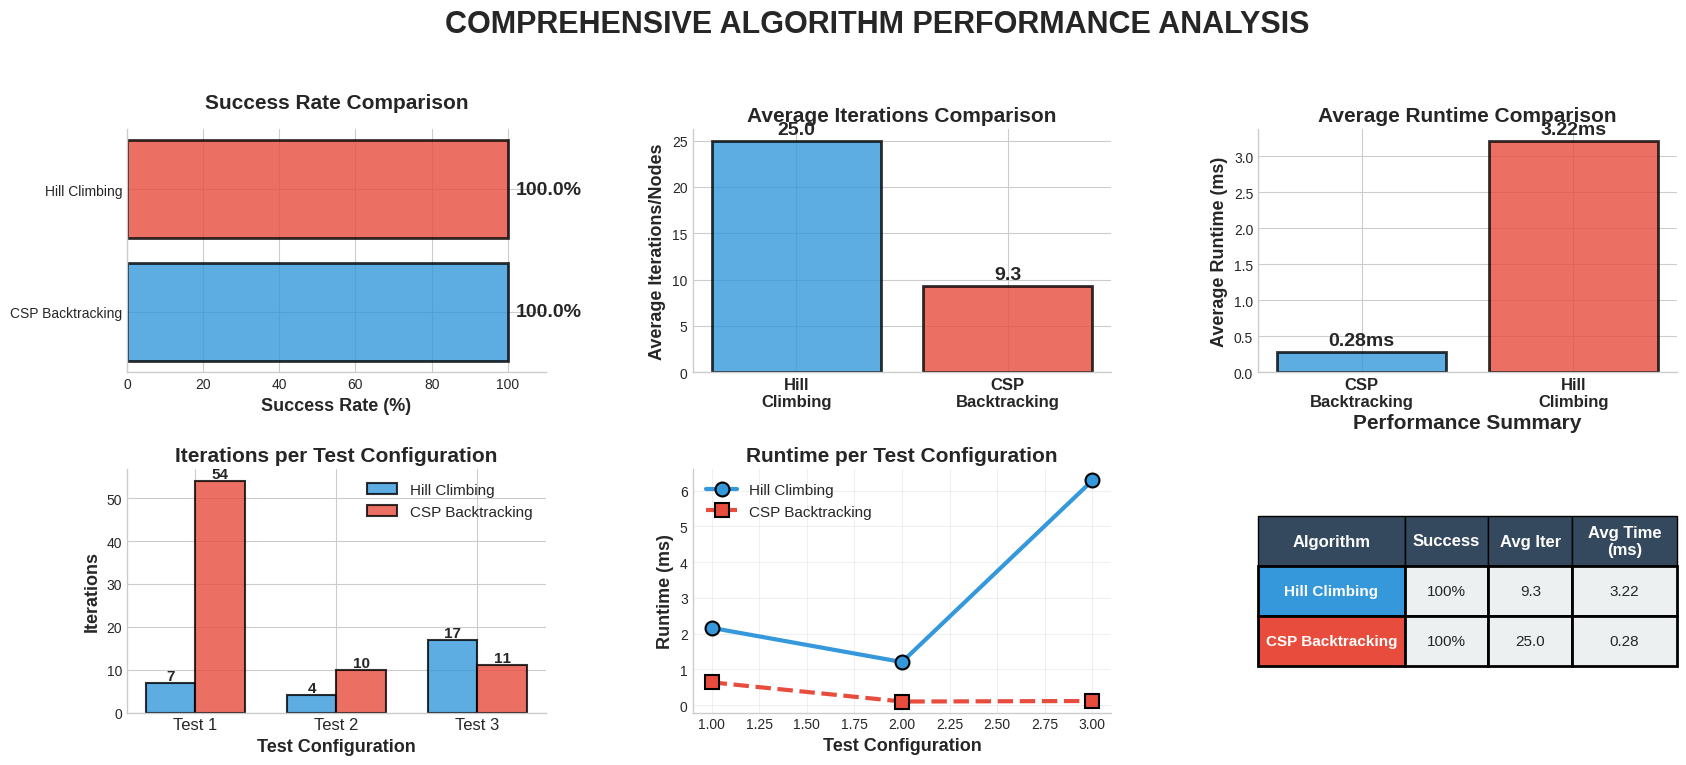


📋 DETAILED RESULTS
 test_id        algorithm  success  iterations     time  restarts  backtracks  conflicts
       1    Hill Climbing     True           7 0.002162         1           0          0
       1 CSP Backtracking     True          54 0.000636         0          80          0
       2    Hill Climbing     True           4 0.001204         1           0          0
       2 CSP Backtracking     True          10 0.000098         0           3          0
       3    Hill Climbing     True          17 0.006288         2           0          0
       3 CSP Backtracking     True          11 0.000113         0           4          0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import numpy as np

# Initialize comparator for N = 8 queens
# This object holds test execution results for both algorithms
comparator = AlgorithmComparator(size=8)

# Run algorithm comparison on 3 predefined test configurations
# It will populate comparator.results with iteration/time/success etc.
comparator.run_comparison(num_runs=3)

# ============================================================================
# MATPLOTLIB VISUALIZATION SECTION
# ============================================================================

print("\n" + "="*80)
print("📈 GENERATING COMPARISON CHARTS")
print("="*80)

# Convert results stored inside AlgorithmComparator into a pandas dataframe
# This makes it easier to group, aggregate & visualize the data
df = pd.DataFrame(comparator.results)

# Apply Seaborn's whitegrid style for clean visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")  # colorful professional palette

# Create main figure for all charts
fig = plt.figure(figsize=(20, 12), facecolor='white')

# GridSpec: 3 rows × 3 columns layout
# hspace/wspace control spacing between charts
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.35)

# Color scheme used consistently across charts
color_hc = '#3498db'   # Blue represents Hill Climbing
color_csp = '#e74c3c'  # Red represents CSP Backtracking

# ============================================================================
# CHART 1: Success Rate Comparison (Top Left)
# ============================================================================

ax1 = fig.add_subplot(gs[0, 0])

# Group data algorithm-wise → count successes & test cases
success_data = df.groupby('algorithm')['success'].agg(['sum', 'count'])

# Calculate success percentage
success_data['rate'] = (success_data['sum'] / success_data['count']) * 100

# Horizontal bar chart
bars = ax1.barh(
    success_data.index,                # algorithm names
    success_data['rate'],              # success%
    color=[color_hc, color_csp],       # colors for algorithms
    edgecolor='black', linewidth=2,
    alpha=0.8
)

# Add % labels at end of each bar
for i, (idx, row) in enumerate(success_data.iterrows()):
    ax1.text(
        row['rate'] + 2,
        i,
        f"{row['rate']:.1f}%",
        va='center',
        fontsize=14,
        fontweight='bold'
    )

ax1.set_xlabel('Success Rate (%)', fontsize=13, fontweight='bold')
ax1.set_title('Success Rate Comparison', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlim(0, 110)  # Allow space for labels

# Remove unnecessary chart borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


# ============================================================================
# CHART 2: Average Iterations (Top Center)
# ============================================================================

ax2 = fig.add_subplot(gs[0, 1])

# Mean iterations/nodes explored per algorithm
avg_iter = df.groupby('algorithm')['iterations'].mean()

# Vertical bar chart
bars = ax2.bar(
    range(len(avg_iter)),
    avg_iter.values,
    color=[color_hc, color_csp],
    edgecolor='black', linewidth=2, alpha=0.8
)

# Print iteration values above bars
for i, v in enumerate(avg_iter.values):
    ax2.text(
        i, v + max(avg_iter.values)*0.03,
        f'{v:.1f}',
        ha='center',
        fontsize=14,
        fontweight='bold'
    )

ax2.set_xticks(range(len(avg_iter)))
ax2.set_xticklabels(['Hill\nClimbing', 'CSP\nBacktracking'], fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Iterations/Nodes', fontsize=13, fontweight='bold')
ax2.set_title('Average Iterations Comparison', fontsize=15, fontweight='bold')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# ============================================================================
# CHART 3: Average Runtime (Top Right)
# ============================================================================

ax3 = fig.add_subplot(gs[0, 2])

# Convert runtime from seconds → milliseconds
avg_time = df.groupby('algorithm')['time'].mean() * 1000

bars = ax3.bar(
    range(len(avg_time)),
    avg_time.values,
    color=[color_hc, color_csp],
    edgecolor='black', linewidth=2, alpha=0.8
)

# Add ms labels above bars
for i, v in enumerate(avg_time.values):
    ax3.text(
        i, v + max(avg_time.values)*0.03,
        f'{v:.2f}ms',
        ha='center',
        fontsize=14,
        fontweight='bold'
    )

ax3.set_xticks(range(len(avg_time)))
ax3.set_xticklabels(['CSP\nBacktracking','Hill\nClimbing' ], fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Runtime (ms)', fontsize=13, fontweight='bold')
ax3.set_title('Average Runtime Comparison', fontsize=15, fontweight='bold')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


# ============================================================================
# CHART 4: Iterations per Test Case (Middle Left)
# ============================================================================

ax4 = fig.add_subplot(gs[1, 0])

# Pivot table: rows = test_id, columns = algorithms, values = iterations
pivot = df.pivot(index='test_id', columns='algorithm', values='iterations')

x = np.arange(len(pivot))  # positions for groups of bars
width = 0.35               # bar width for grouped bar chart

# Bars for Hill Climbing
bars1 = ax4.bar(
    x - width/2, pivot['Hill Climbing'], width,
    label='Hill Climbing',
    color=color_hc,
    edgecolor='black', linewidth=1.5, alpha=0.8
)

# Bars for CSP Backtracking
bars2 = ax4.bar(
    x + width/2, pivot['CSP Backtracking'], width,
    label='CSP Backtracking',
    color=color_csp,
    edgecolor='black', linewidth=1.5, alpha=0.8
)

# Add labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold'
        )

ax4.set_xlabel('Test Configuration', fontsize=13, fontweight='bold')
ax4.set_ylabel('Iterations', fontsize=13, fontweight='bold')
ax4.set_title('Iterations per Test Configuration', fontsize=15, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f'Test {i+1}' for i in range(len(x))], fontsize=12)
ax4.legend(fontsize=11, framealpha=0.9)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


# ============================================================================
# CHART 5: Runtime per Test Case (Middle Center)
# ============================================================================

ax5 = fig.add_subplot(gs[1, 1])

# Plot runtime trend per test case for both algorithms
for algo, color, marker, linestyle in [
    ('Hill Climbing', color_hc, 'o', '-'),
    ('CSP Backtracking', color_csp, 's', '--')
]:
    data = df[df['algorithm'] == algo]
    ax5.plot(
        data['test_id'],
        data['time'] * 1000,           # convert to milliseconds
        marker=marker,
        linewidth=3,
        markersize=10,
        label=algo,
        color=color,
        linestyle=linestyle,
        markeredgecolor='black',
        markeredgewidth=1.5
    )

ax5.set_xlabel('Test Configuration', fontsize=13, fontweight='bold')
ax5.set_ylabel('Runtime (ms)', fontsize=13, fontweight='bold')
ax5.set_title('Runtime per Test Configuration', fontsize=15, fontweight='bold')
ax5.legend(fontsize=11, framealpha=0.9)
ax5.grid(True, alpha=0.3)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)


# ============================================================================
# CHART 6: Summary Statistics Table (Middle Right)
# ============================================================================

ax9 = fig.add_subplot(gs[1, 2])
ax9.axis('off')  # No axes—only a table

# Prepare summary table values
table_data = []
for algo in ['Hill Climbing', 'CSP Backtracking']:
    algo_df = df[df['algorithm'] == algo]
    table_data.append([
        algo,
        f"{(algo_df['success'].sum() / len(algo_df) * 100):.0f}%",
        f"{algo_df['iterations'].mean():.1f}",
        f"{(algo_df['time'].mean() * 1000):.2f}"
    ])

# Create a matplotlib table
table = ax9.table(
    cellText=table_data,
    colLabels=['Algorithm', 'Success', 'Avg Iter', 'Avg Time\n(ms)'],
    cellLoc='center',
    loc='center',
    colWidths=[0.35, 0.2, 0.2, 0.25]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style table rows and cells
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', fontsize=12)
        else:
            if j == 0:
                cell.set_facecolor(color_hc if i == 1 else color_csp)
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1')
            cell.set_edgecolor('black')
            cell.set_linewidth(2)

ax9.set_title('Performance Summary', fontsize=15, fontweight='bold', pad=30)


# ============================================================================
# MAIN TITLE FOR ENTIRE FIGURE
# ============================================================================

fig.suptitle(
    'COMPREHENSIVE ALGORITHM PERFORMANCE ANALYSIS',
    fontsize=22,
    fontweight='bold',
    y=0.98
)

plt.tight_layout()
plt.show()


# ============================================================================
# DETAILED GRID OUTPUT IN TEXT FORM (Console)
# ============================================================================

print("\n" + "="*80)
print("📋 DETAILED RESULTS")
print("="*80)

results_df = pd.DataFrame(comparator.results)
print(results_df.to_string(index=False))


## UNIFIED INTERFACE OF BOTH ALORITHMS FOR COMPARISON OF 3 TEST CASES

In [ ]:
# ============================================================================
# CELL 7: UNIFIED COMPARISON INTERFACE (Connected to Real Solvers)
# ============================================================================

from IPython.display import HTML, display
import json

def create_unified_comparison_interface_v2(num_tests=3):
    """Create unified interface with REAL solver results"""

    # Generate test configurations
    comparator = AlgorithmComparator(size=8)
    test_configs = comparator.generate_test_configs(num_tests)

    all_results = []

    for idx, config in enumerate(test_configs, 1):

        # Run Hill Climbing
        hc_solver = HillClimbingSolver(8)
        hc_result = hc_solver.solve(config)

        # Run CSP Backtracking
        csp_solver = CSPBacktrackingSolver(8)
        csp_result = csp_solver.solve(config)

        all_results.append({
            'test_id': idx,
            'config': config,
            'hc': {
                'success': hc_result['success'],
                'solution': hc_result['solution'],
                'iterations': hc_result['iterations'],
                'time': hc_result['time'],
                'restarts': hc_result.get('restarts', 0)
            },
            'csp': {
                'success': csp_result['success'],
                'solution': csp_result['solution'],
                'iterations': csp_result['iterations'],
                'time': csp_result['time'],
                'backtracks': csp_result['backtracks']
            }
        })

    # Embed results as JSON in HTML
    results_json = json.dumps(all_results)

    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <style>
            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                padding: 20px;
                margin: 0;
            }}
            .container {{
                max-width: 1400px;
                margin: 0 auto;
                background: white;
                border-radius: 20px;
                padding: 30px;
                box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            }}
            h1 {{
                text-align: center;
                color: #667eea;
                margin-bottom: 10px;
            }}
            .subtitle {{
                text-align: center;
                color: #666;
                margin-bottom: 30px;
            }}
            .comparison-grid {{
                display: grid;
                grid-template-columns: 1fr 1fr;
                gap: 20px;
                margin-top: 20px;
            }}
            .algorithm-panel {{
                border: 3px solid #667eea;
                border-radius: 15px;
                padding: 20px;
                background: #f8f9fa;
            }}
            .algorithm-panel h2 {{
                color: #667eea;
                margin-top: 0;
                text-align: center;
            }}
            .board {{
                display: grid;
                grid-template-columns: repeat(8, 45px);
                grid-template-rows: repeat(8, 45px);
                gap: 0;
                margin: 20px auto;
                border: 2px solid #333;
                width: fit-content;
            }}
            .square {{
                width: 45px;
                height: 45px;
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 30px;
            }}
            .light {{ background: #f0d9b5; }}
            .dark {{ background: #b58863; }}
            .stats {{
                background: white;
                padding: 15px;
                border-radius: 10px;
                margin: 15px 0;
            }}
            .stat-row {{
                display: flex;
                justify-content: space-between;
                padding: 8px 0;
                border-bottom: 1px solid #eee;
            }}
            .stat-label {{
                font-weight: 600;
                color: #555;
            }}
            .stat-value {{
                color: #667eea;
                font-weight: 700;
            }}
            .stat-value.success {{ color: #51cf66; }}
            .stat-value.fail {{ color: #ff6b6b; }}
            button {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                border: none;
                padding: 12px 24px;
                border-radius: 25px;
                font-size: 14px;
                font-weight: 600;
                cursor: pointer;
                margin: 5px;
                transition: transform 0.2s;
            }}
            button:hover {{
                transform: translateY(-2px);
            }}
            button:disabled {{
                opacity: 0.5;
                cursor: not-allowed;
                transform: none;
            }}
            .controls {{
                text-align: center;
                margin: 20px 0;
            }}
            .winner {{
                text-align: center;
                font-size: 20px;
                font-weight: bold;
                color: #51cf66;
                margin: 20px 0;
                padding: 15px;
                background: #f0f9f0;
                border-radius: 10px;
            }}
            .test-selector {{
                text-align: center;
                margin: 20px 0;
                font-size: 16px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>8-Queens Algorithm Showdown</h1>
            <p class="subtitle">Real-time comparison of Hill Climbing vs CSP Backtracking</p>

            <div class="controls">
                <button onclick="prevTest()" id="prevBtn">⬅️ Previous</button>
                <span class="test-selector" id="testSelector">Test 1 of 3</span>
                <button onclick="nextTest()" id="nextBtn">Next ➡️</button>
            </div>

            <div id="winner" class="winner"></div>

            <div class="comparison-grid">
                <div class="algorithm-panel">
                    <h2>🏔️ Hill Climbing</h2>
                    <div class="board" id="hc-board"></div>
                    <div class="stats" id="hc-stats"></div>
                </div>

                <div class="algorithm-panel">
                    <h2>🧩 CSP Backtracking</h2>
                    <div class="board" id="csp-board"></div>
                    <div class="stats" id="csp-stats"></div>
                </div>
            </div>
        </div>

        <script>
            // ✅ Real results from Python solvers
            const RESULTS = {results_json};
            let currentTestIndex = 0;

            function renderBoard(containerId, state) {{
                const container = document.getElementById(containerId);
                container.innerHTML = '';

                if (!state || state.length !== 8) {{
                    container.innerHTML = '<p style="text-align:center;color:#ff6b6b;">Invalid state</p>';
                    return;
                }}

                for (let row = 0; row < 8; row++) {{
                    for (let col = 0; col < 8; col++) {{
                        const square = document.createElement('div');
                        square.className = 'square ' + ((row + col) % 2 === 0 ? 'light' : 'dark');
                        if (state[col] === row) {{
                            square.innerHTML = '♛';
                            square.style.color = '#2d5016';
                            square.style.fontWeight = 'bold';
                        }}
                        container.appendChild(square);
                    }}
                }}
            }}

            function renderStats(containerId, result, algorithm) {{
                const container = document.getElementById(containerId);
                const statusClass = result.success ? 'success' : 'fail';
                const statusText = result.success ? '✅ Success' : '❌ Failed';
                const extraMetric = algorithm === 'hc' ?
                    `<div class="stat-row">
                        <span class="stat-label">Restarts:</span>
                        <span class="stat-value">${{result.restarts}}</span>
                    </div>` :
                    `<div class="stat-row">
                        <span class="stat-label">Backtracks:</span>
                        <span class="stat-value">${{result.backtracks}}</span>
                    </div>`;

                container.innerHTML = `
                    <div class="stat-row">
                        <span class="stat-label">Status:</span>
                        <span class="stat-value ${{statusClass}}">${{statusText}}</span>
                    </div>
                    <div class="stat-row">
                        <span class="stat-label">Iterations:</span>
                        <span class="stat-value">${{result.iterations}}</span>
                    </div>
                    <div class="stat-row">
                        <span class="stat-label">Runtime:</span>
                        <span class="stat-value">${{(result.time * 1000).toFixed(3)}} ms</span>
                    </div>
                    ${{extraMetric}}
                `;
            }}

            function updateDisplay() {{
                const test = RESULTS[currentTestIndex];

                // Update boards
                renderBoard('hc-board', test.hc.solution);
                renderBoard('csp-board', test.csp.solution);

                // Update stats
                renderStats('hc-stats', test.hc, 'hc');
                renderStats('csp-stats', test.csp, 'csp');

                // Update test selector
                document.getElementById('testSelector').textContent =
                    `Test ${{currentTestIndex + 1}} of ${{RESULTS.length}}`;

                // Update buttons
                document.getElementById('prevBtn').disabled = currentTestIndex === 0;
                document.getElementById('nextBtn').disabled = currentTestIndex === RESULTS.length - 1;

                // Determine winner
                const winner = document.getElementById('winner');
                const hcSuccess = test.hc.success;
                const cspSuccess = test.csp.success;

                if (cspSuccess && !hcSuccess) {{
                    winner.innerHTML = '🏆 CSP Backtracking wins (found solution, HC failed)';
                    winner.style.background = '#e3f2fd';
                }} else if (hcSuccess && !cspSuccess) {{
                    winner.innerHTML = '🏆 Hill Climbing wins (found solution, CSP failed)';
                    winner.style.background = '#f3e5f5';
                }} else if (hcSuccess && cspSuccess) {{
                    if (test.hc.time < test.csp.time) {{
                        winner.innerHTML = `🏆 Hill Climbing wins (faster: ${{(test.hc.time*1000).toFixed(2)}}ms vs ${{(test.csp.time*1000).toFixed(2)}}ms)`;
                        winner.style.background = '#f3e5f5';
                    }} else {{
                        winner.innerHTML = `🏆 CSP Backtracking wins (faster: ${{(test.csp.time*1000).toFixed(2)}}ms vs ${{(test.hc.time*1000).toFixed(2)}}ms)`;
                        winner.style.background = '#e3f2fd';
                    }}
                }} else {{
                    winner.innerHTML = '⚖️ Both algorithms failed';
                    winner.style.background = '#ffebee';
                    winner.style.color = '#ff6b6b';
                }}

                updateAggregateStats();
            }}

            function updateAggregateStats() {{
                const hcSuccessCount = RESULTS.filter(r => r.hc.success).length;
                const cspSuccessCount = RESULTS.filter(r => r.csp.success).length;

                const hcAvgTime = RESULTS.reduce((sum, r) => sum + r.hc.time, 0) / RESULTS.length;
                const cspAvgTime = RESULTS.reduce((sum, r) => sum + r.csp.time, 0) / RESULTS.length;

                const hcAvgIter = RESULTS.reduce((sum, r) => sum + r.hc.iterations, 0) / RESULTS.length;
                const cspAvgIter = RESULTS.reduce((sum, r) => sum + r.csp.iterations, 0) / RESULTS.length;

                document.getElementById('aggregateStats').innerHTML = `
                    <div class="aggregate-card">
                        <h4 style="color: #667eea; margin-top: 0;">🏔️ Hill Climbing</h4>
                        <p><strong>Success Rate:</strong> ${{hcSuccessCount}}/${{RESULTS.length}} (${{(hcSuccessCount/RESULTS.length*100).toFixed(0)}}%)</p>
                        <p><strong>Avg Runtime:</strong> ${{(hcAvgTime*1000).toFixed(3)}} ms</p>
                        <p><strong>Avg Iterations:</strong> ${{hcAvgIter.toFixed(1)}}</p>
                    </div>
                    <div class="aggregate-card">
                        <h4 style="color: #667eea; margin-top: 0;">🧩 CSP Backtracking</h4>
                        <p><strong>Success Rate:</strong> ${{cspSuccessCount}}/${{RESULTS.length}} (${{(cspSuccessCount/RESULTS.length*100).toFixed(0)}}%)</p>
                        <p><strong>Avg Runtime:</strong> ${{(cspAvgTime*1000).toFixed(3)}} ms</p>
                        <p><strong>Avg Iterations:</strong> ${{cspAvgIter.toFixed(1)}}</p>
                    </div>
                `;
            }}

            function nextTest() {{
                if (currentTestIndex < RESULTS.length - 1) {{
                    currentTestIndex++;
                    updateDisplay();
                }}
            }}

            function prevTest() {{
                if (currentTestIndex > 0) {{
                    currentTestIndex--;
                    updateDisplay();
                }}
            }}

            // Initialize display
            updateDisplay();
        </script>
    </body>
    </html>
    """

    return HTML(html)

# Display the interface with real results
display(create_unified_comparison_interface_v2(num_tests=3))
